<a href="https://colab.research.google.com/github/Nancy123a/stock_price_prediction/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
AAPL=pd.read_csv('sample_data/AAPL.csv')
AAPL.head(5)

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


<Axes: >

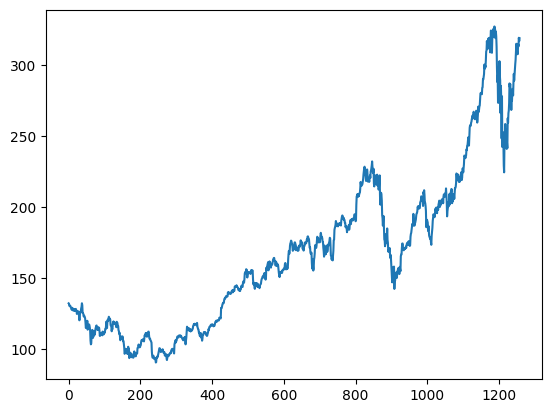

In [4]:
import matplotlib.pyplot as plt
AAPL['close'].plot(kind='line')

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=AAPL['close']
df1=scaler.fit_transform(np.array(df).reshape(-1,1))
print(df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


Divide the dataset int 65% training and 35% test

In [8]:
train_size=int(len(df1)*0.65)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [9]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [12]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1) # because we have only one feature (Close)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1) # because we have only one feature (Close)

In [13]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - loss: 0.0435 - val_loss: 0.0398
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 7.0419e-04 - val_loss: 0.0041
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 6.3840e-04 - val_loss: 0.0046
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 6.2060e-04 - val_loss: 0.0036
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - loss: 6.0007e-04 - val_loss: 0.0036
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 5.6240e-04 - val_loss: 0.0037
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 5.5788e-04 - val_loss: 0.0034
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 5.4686e-04 - val_loss: 0.0033
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 5.7828e-04 - val_loss: 0.0034
Epoch 12/

In [17]:
import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [18]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

143.28801855342877

In [20]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

239.90612690442947

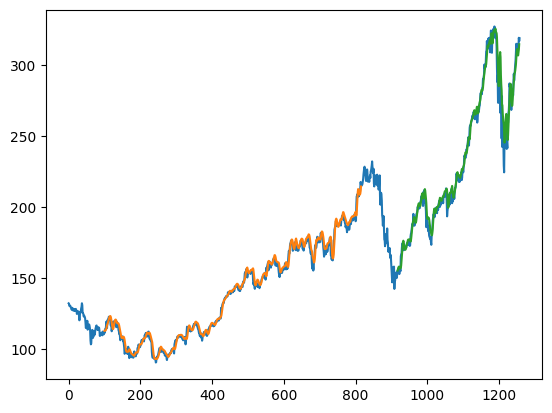

In [21]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


- How to make predictions for the next 10 days using a trained model in a time series forecasting scenario.
- The code is designed to iteratively predict the next day's value based on the previous n_steps days of data.
- It handles the initial cases where there may not be enough data to fill the full n_steps by using the available data.
- Once sufficient data is accumulated, it continuously updates temp_input by removing the oldest data point and adding the newest prediction.
- This approach is useful for rolling predictions in time series forecasting, where each new prediction is based on the most recent data available.

In [23]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [24]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [27]:
len(temp_input)

101

In [25]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.963764]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.90

In [28]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

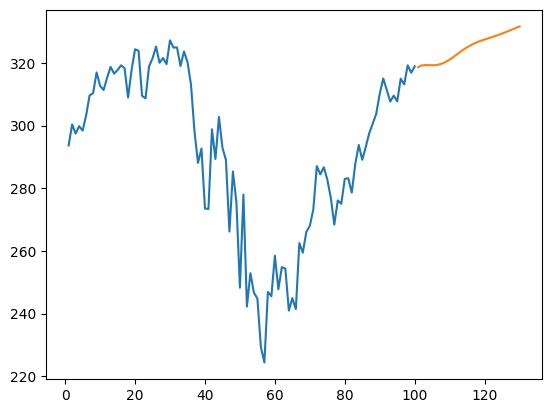

In [29]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

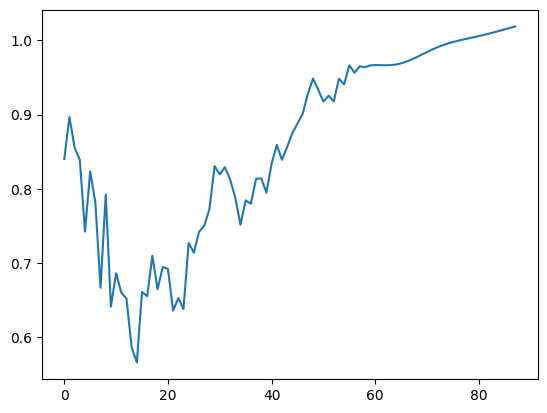

In [30]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

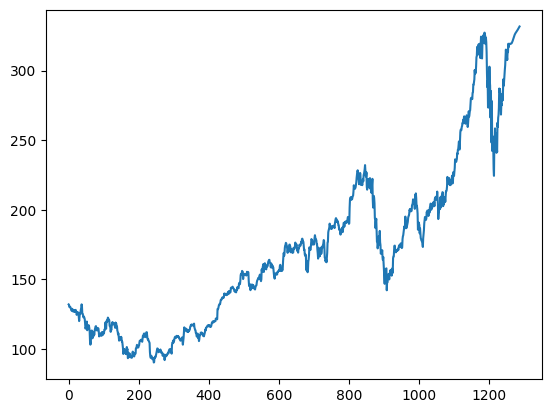

In [32]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)